# Berkeley NLP Capstone

In [1]:
#Steven Johannemann, Zoe Ouyang, Chloe Zhang
#Import all needed packages
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
import string
from string import punctuation
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec, KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## Import Dataset and Word2vec file

In [2]:
#Load in the data
df_ori = pd.read_csv('yelp.csv')

In [3]:
#Basic View of Data
df_ori.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
#Shape of Data
df_ori.shape

(10000, 10)

## Basic Data Manipulation

In [5]:
#Create a new column for Binary Classification where 1-2 stars = negative (0) and 3-5 stars = positive (1)
df_ori["attitude"] = np.where(df_ori["stars"] >= 3, 1, 0)
#Create a new data frame that only contains the following columns
df = df_ori[['text','attitude']]

## Data Exploration and Visualization

In [6]:
#Examine the distribution of the 'attitude' column
df['attitude'].value_counts()

1    8324
0    1676
Name: attitude, dtype: int64

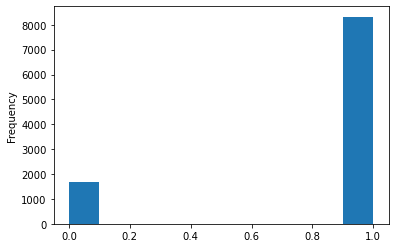

In [7]:
df['attitude'].astype(int).plot.hist();

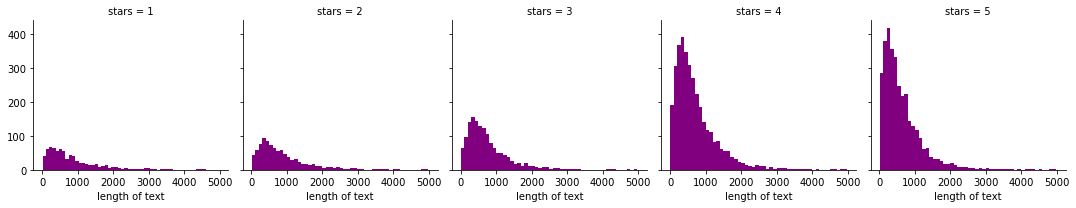

In [8]:
#Correlation between review length and rating may be insightful
df_ori['length of text'] = df_ori['text'].apply(len)
graph = sns.FacetGrid(data=df_ori,col='stars')
graph.map(plt.hist,'length of text',bins=50,color='purple')

In [9]:
# can work more on this later to create more visuals and figures

## Data Pre-processing

In [10]:
#Function for data cleaning using regular expressions
import re
def function_clean(text):
    text = re.sub(r"http\S+", "", text) #hyperlinks
    text = re.sub("@[^\s]*", "", text)
    text = re.sub("#[^\s]*", "", text)
    text = re.sub('[0-9]*[+-:]*[0-9]+', '', text) #Dates
    text = re.sub("'s", "", text) # " 's "
    return text

In [11]:
#Apply the regex function to text column
df['text'] = df['text'].apply(lambda text: function_clean(text))
X = df['text']
y = df["attitude"]

<ipython-input-11-2c6fb3533ba0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda text: function_clean(text))


In [12]:
stop_words = set(stopwords.words("english"))
porter = PorterStemmer()

def my_tokenizer(sentence):
    listofwords = sentence.strip().split()          
    listof_words = []    
    for word in listofwords:
        if not word in stop_words:
            stem_word = porter.stem(word)
            for punctuation_mark in string.punctuation:
                stem_word = stem_word.replace(punctuation_mark, '').lower()
            if len(word)>2:
                listof_words.append(stem_word)
    return(listof_words)

#preprocess the text.
def preprocess_corpus(texts):
    mystopwords = set(stopwords.words("english"))
    def remove_stops_digits(tokens):
        #Nested function that lowercases, removes stopwords and digits from a list of tokens
        return [token.lower() for token in tokens if token not in mystopwords and not token.isdigit()
               and token not in punctuation and len(token) > 2]
    #This return statement below uses the above function to process twitter tokenizer output further. 
    return [remove_stops_digits(word_tokenize(text)) for text in texts]

# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        if count_for_this == 0:
            count_for_this = 1
        feats.append(feat_for_this/count_for_this)
    return feats

In [13]:
#Training/testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [14]:
#Load the pre-trained word2vec model and the dataset
data_path= r"C:\Users\Steven Johannemann\Desktop\Capstone\Capstone Notebooks"
path_to_model = os.path.join(data_path,'GoogleNews-vectors-negative300.bin')
training_data_path = os.path.join(data_path, "sentiment_sentences.txt")

#Load W2V model. This will take some time. 
%time w2v_model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
print('done loading Word2Vec')

#Read text data, cats.
#the file path consists of tab separated sentences and cats.
train_texts = X_train.tolist()
train_cats = y_train.tolist()
test_texts = X_test.tolist()
test_cats = y_test.tolist()
#fh = open(training_data_path)
#for line in fh:
#    text, sentiment = line.split("\t")
#    texts.append(text)
#    cats.append(sentiment)

Wall time: 19.5 s
done loading Word2Vec


In [15]:
# Inspect the model
word2vec_vocab = w2v_model.vocab.keys()
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]
print(len(word2vec_vocab))

3000000


In [356]:
#one thing to note is that word embedding models do not require the same amount of cleaning

## Heuristic NLP model (VADER sentiment analysis)

In [357]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to C:\Users\Steven
[nltk_data]     Johannemann\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [358]:
# Transfer type of data from DataFrame into dictionary and preprocess the text for later sentiment intensity analysis
import re
PATTERN = r'[^a-zA]' 
#df_senti = df_ori[['text']]
df_senti = X_test.to_frame()
senti=df_senti.to_dict('records') 
for cell in senti: 
    cell_1 = cell['text'].replace('\n','').replace('\n\n','').lower()
    cell_2 = re.sub(PATTERN,r' ',cell_1)
    cell_2_no_punc= cell_2.translate(str.maketrans('','', string.punctuation))
    ss = sid.polarity_scores(cell_2_no_punc)
    cell.update(ss)

In [420]:
df_senti_score=pd.DataFrame.from_dict(senti)
df_senti_score["prediction"] = np.where(df_senti_score["pos"] > df_senti_score["neg"], 1, 0)
df_vader = pd.concat([df_senti_score.reset_index(drop=True),y_test.to_frame().reset_index(drop=True)], axis=1)
df_vader["match"] = np.where(df_vader["prediction"] == df_vader["attitude"], 1, 0)
df_vader.head()

,text,neg,neu,pos,compound,prediction,attitude,match
0,First let me start by saying they're beer sele...,0.055,0.757,0.188,0.9784,1,1,1
1,My boyfriends company has been doing business ...,0.000,0.705,0.295,0.8313,1,1,1
2,This place used to be amazing. My favorite me...,0.101,0.835,0.064,-0.9516,0,0,1
3,I took my daughter there to get her nose pierc...,0.000,0.590,0.410,0.9693,1,1,1
4,"This place is perfect! Great food, great servi...",0.000,0.644,0.356,0.9628,1,1,1


In [361]:
from itertools import product
cats = ['{0[0]}{0[1]}'.format(tup) for tup in product([0,1], [0,1])]
pd.Categorical((df_vader.attitude.astype(str)+df_vader.prediction.astype(str)),categories=cats).value_counts()

00     198
01     287
10      92
11    2423
dtype: int64

In [362]:
vader_accuracy = df_vader["match"].sum()/df_vader["match"].count()
print(f'Accuracy of the Heuristic Model {vader_accuracy}.')

Accuracy of the Heuristic Model 0.8736666666666667.


## Feature Extraction using BoW, Tf-idf and Word2Vec

In [17]:
#Use CountVectorizer for BoW and TfidfVectorizer for Tf-idf
cv = CountVectorizer(tokenizer = my_tokenizer, ngram_range=(1,3), min_df = 0.001).fit(X_train)
tfidf = TfidfVectorizer(tokenizer = my_tokenizer, ngram_range=(1,3), min_df = 0.001).fit(X_train)
X_traintfidf = tfidf.transform(X_train)
X_testtfidf = tfidf.transform(X_test)
X_traincv = cv.transform(X_train)
X_testcv = cv.transform(X_test)

C:\Users\Steven Johannemann\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [18]:
train_texts_processed = preprocess_corpus(train_texts)
train_texts_vectors = embedding_feats(train_texts_processed)

test_texts_processed = preprocess_corpus(test_texts)
test_texts_vectors = embedding_feats(test_texts_processed)

In [19]:
#Preview First 100 Feature Names
#cv.get_feature_names()[0:100]
#tfidf.get_feature_names()[0:100]

In [20]:
#Shape of the training sets after feature extraction
print(X_traincv.shape)
print(X_traintfidf.shape)
print(len(train_texts_vectors))

(7000, 10359)
(7000, 10359)
7000


## Data Augmentation using SMOTE

In [21]:
sm = SMOTE(random_state=6)
X_balcv, y_balcv = sm.fit_resample(X_traincv, y_train)
X_baltfidf, y_baltfidf = sm.fit_resample(X_traintfidf, y_train)

df_train_vect = DataFrame(train_texts_vectors,columns=[f"{x}" for x in range(0,300)])
X_bal_w2v_train, y_bal_w2v_train = sm.fit_resample(df_train_vect, y_train)
X_bal_w2v_test = DataFrame(test_texts_vectors,columns=[f"{x}" for x in range(0,300)])

print(y_balcv.value_counts())
print(y_baltfidf.value_counts())
print(y_bal_w2v_train.value_counts())

0    5809
1    5809
Name: attitude, dtype: int64
0    5809
1    5809
Name: attitude, dtype: int64
0    5809
1    5809
Name: attitude, dtype: int64


In [22]:
X_bal_w2v_train.shape

In [229]:
X_bal_w2v_train.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.023744,0.060219,0.016482,0.090105,-0.007244,-0.025589,0.034035,-0.113440,0.054746,0.114717,...,-0.056137,0.021115,-0.082917,0.063784,0.043157,-0.026655,-0.040477,-0.025094,0.054904,0.021000
1,-0.015911,0.043575,-0.013652,0.100484,-0.005798,-0.015063,0.061395,-0.072637,0.067469,0.103962,...,-0.038242,0.030037,-0.157944,0.021459,-0.003957,-0.000028,-0.006192,-0.096130,0.038877,-0.055206
2,-0.046297,0.020967,-0.013677,0.139245,-0.012362,0.013418,0.070208,-0.079559,0.020009,0.104837,...,-0.003211,0.003720,-0.082918,0.050714,0.012108,-0.075983,0.002162,-0.033747,0.014359,-0.000162
3,0.008420,0.075425,0.024882,0.172981,-0.074955,-0.002558,0.046766,-0.103122,-0.002265,0.140211,...,-0.073666,0.068075,-0.044182,0.050248,0.045441,-0.017130,-0.008546,-0.096064,0.009728,0.051083
4,-0.017591,0.019987,-0.016805,0.129858,-0.052706,-0.029344,0.066977,-0.084492,0.057343,0.090267,...,-0.029835,-0.000642,-0.075613,0.019254,-0.020711,-0.010652,-0.004084,-0.041545,0.014758,-0.033203


## Supervised Machine Learning Models

In [363]:
#Bootstrap for Confidence intervals for B = 1000, n = len(predrmfr)
#default 95% confidence, plot accuracy distribution
#test and osr_pred are 1d arrays
def confidence_bootstrap(test, ospred, conf = 0.95, b = 1000, acc = True):
    sim_acc = []
    sim_diff = []
    n = len(ospred)
    ossample = accuracy_score(test,ospred)
    
    df_data = {'real':test,'pred':ospred}
    sample_data = pd.DataFrame(df_data, columns =['real','pred'])
    
    #simulation
    for i in range(n):
        bsample = sample_data.sample(n=len(ospred),replace=True)
        sim_acc.append(accuracy_score(bsample['real'],bsample['pred']))
        sim_diff.append(accuracy_score(bsample['real'],bsample['pred']) - ossample)
    
    sim_acc.sort()
    sim_diff.sort()
   
    #onfidence Interval
    lower = int(np.floor(n*(1-conf)/2))
    upper = int(np.floor(n*(1+conf)/2))
    
    #Plots
    if acc == False:
        sns.distplot(sim_diff)
        plt.xlabel("Difference")
        plt.title("Distribution of Difference of OSR2")
    else:
        sns.distplot(sim_acc)
        plt.xlabel("Accuracy")
        plt.title("Distribution of Accuracy")
    print("Confidence Interval:", sim_acc[lower],sim_acc[upper])
    print("Lower and Upper Quantiles:",sim_diff[lower],sim_diff[upper])

#### Naive Bayes Models

In [24]:
#MN Naive Bayes Import
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
mnb = MultinomialNB()

In [25]:
#MN Naive Bayes using Bag of Words
mnb.fit(X_balcv,y_balcv)
predmnb = mnb.predict(X_testcv)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))
print(f'f1 score: {f1_score(y_test,predmnb)}')

Confusion Matrix for Multinomial Naive Bayes:
[[ 368  117]
 [ 233 2282]]
Score: 88.33
Classification Report:               precision    recall  f1-score   support

           0       0.61      0.76      0.68       485
           1       0.95      0.91      0.93      2515

    accuracy                           0.88      3000
   macro avg       0.78      0.83      0.80      3000
weighted avg       0.90      0.88      0.89      3000

f1 score: 0.9287749287749286


Confidence Interval: 0.872 0.8946666666666667
Lower and Upper Quantiles: -0.011333333333333306 0.011333333333333417


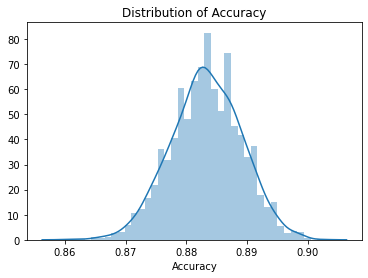

In [26]:
confidence_bootstrap(y_test.values.tolist(),predmnb)

In [27]:
#MN Naive Bayes using Tf-idf
mnb.fit(X_baltfidf,y_baltfidf)
predmnb = mnb.predict(X_testtfidf)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))
print(f'f1 score: {f1_score(y_test,predmnb)}')

Confusion Matrix for Multinomial Naive Bayes:
[[ 410   75]
 [ 348 2167]]
Score: 85.9
Classification Report:               precision    recall  f1-score   support

           0       0.54      0.85      0.66       485
           1       0.97      0.86      0.91      2515

    accuracy                           0.86      3000
   macro avg       0.75      0.85      0.79      3000
weighted avg       0.90      0.86      0.87      3000

f1 score: 0.911078410763086


In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(X_bal_w2v_train)
scaled_test = scaler.fit_transform(X_bal_w2v_test)
#MN Naive Bayes using Word2vec
mnb.fit(scaled_train, y_bal_w2v_train)
predmnb = mnb.predict(scaled_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))
print(f'f1 score: {f1_score(y_test,predmnb)}')

Confusion Matrix for Multinomial Naive Bayes:
[[ 338  147]
 [ 654 1861]]
Score: 73.3
Classification Report:               precision    recall  f1-score   support

           0       0.34      0.70      0.46       485
           1       0.93      0.74      0.82      2515

    accuracy                           0.73      3000
   macro avg       0.63      0.72      0.64      3000
weighted avg       0.83      0.73      0.76      3000

f1 score: 0.8229051514481539


In [29]:
'''# Random Forest
from sklearn.ensemble import RandomForestClassifier

review_random_forest = RandomForestClassifier(random_state=6)
review_random_forest.fit(X_bal_w2v_train, y_bal_w2v_train)
herro = review_random_forest.predict(X_bal_w2v_test)
print(f"Random Forest: {review_random_forest.score(X_bal_w2v_train, y_bal_w2v_train)}")
# Random Forest: 0.9998278533310381
print(f"Random Forest: {review_random_forest.score(X_bal_w2v_test, y_test)}")
# Random Forest: 0.874
'''

'# Random Forest\nfrom sklearn.ensemble import RandomForestClassifier\n\nreview_random_forest = RandomForestClassifier(random_state=6)\nreview_random_forest.fit(X_bal_w2v_train, y_bal_w2v_train)\nherro = review_random_forest.predict(X_bal_w2v_test)\nprint(f"Random Forest: {review_random_forest.score(X_bal_w2v_train, y_bal_w2v_train)}")\n# Random Forest: 0.9998278533310381\nprint(f"Random Forest: {review_random_forest.score(X_bal_w2v_test, y_test)}")\n# Random Forest: 0.874\n'

In [30]:
'''
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,herro))
print("Score:",round(accuracy_score(y_test,herro)*100,2))
print("Classification Report:",classification_report(y_test,herro))
print(f'f1 score: {f1_score(y_test,herro)}')
# Tuning Hyperparameters: n_estimators, max_features, min_sample_leaf
# https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
'''

'\nprint("Confusion Matrix for Multinomial Naive Bayes:")\nprint(confusion_matrix(y_test,herro))\nprint("Score:",round(accuracy_score(y_test,herro)*100,2))\nprint("Classification Report:",classification_report(y_test,herro))\nprint(f\'f1 score: {f1_score(y_test,herro)}\')\n# Tuning Hyperparameters: n_estimators, max_features, min_sample_leaf\n# https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/\n'

#### Lasso Regression

In [31]:
#Logistic Regression Import
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty = 'l1', solver='saga',random_state=6, C =10.0)

In [32]:
#Lasso Regression using Bag of Words
logreg.fit(X_balcv,y_balcv)
predlog = logreg.predict(X_testcv)
print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test,predlog))
print("Score:",round(accuracy_score(y_test,predlog)*100,2))
print("Classification Report:",classification_report(y_test,predlog))

Confusion Matrix for Logistic Regression:
[[ 318  167]
 [ 284 2231]]
Score: 84.97
Classification Report:               precision    recall  f1-score   support

           0       0.53      0.66      0.59       485
           1       0.93      0.89      0.91      2515

    accuracy                           0.85      3000
   macro avg       0.73      0.77      0.75      3000
weighted avg       0.87      0.85      0.86      3000



C:\Users\Steven Johannemann\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [33]:
#Lasso Regression using Tf-idf
logreg.fit(X_baltfidf,y_baltfidf)
predlog = logreg.predict(X_testtfidf)
print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test,predlog))
print("Score:",round(accuracy_score(y_test,predlog)*100,2))
print("Classification Report:",classification_report(y_test,predlog))

Confusion Matrix for Logistic Regression:
[[ 343  142]
 [ 248 2267]]
Score: 87.0
Classification Report:               precision    recall  f1-score   support

           0       0.58      0.71      0.64       485
           1       0.94      0.90      0.92      2515

    accuracy                           0.87      3000
   macro avg       0.76      0.80      0.78      3000
weighted avg       0.88      0.87      0.88      3000



C:\Users\Steven Johannemann\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [34]:
#Lasso Regression using Word2vec ##########################WHY DOES SCALED WORK BETTER?
logreg.fit(X_bal_w2v_train, y_bal_w2v_train)
predlog = logreg.predict(X_bal_w2v_test)
print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test,predlog))
print("Score:",round(accuracy_score(y_test,predlog)*100,2))
print("Classification Report:",classification_report(y_test,predlog))

Confusion Matrix for Logistic Regression:
[[ 385  100]
 [ 368 2147]]
Score: 84.4
Classification Report:               precision    recall  f1-score   support

           0       0.51      0.79      0.62       485
           1       0.96      0.85      0.90      2515

    accuracy                           0.84      3000
   macro avg       0.73      0.82      0.76      3000
weighted avg       0.88      0.84      0.86      3000



C:\Users\Steven Johannemann\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


#### XGBoost

In [35]:
#XGBoost Import
import xgboost as xgb#!pip install hyperopt
import hyperopt as hyp
from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
random_state = 123
n_iter=20

# BAG OF WORDS

In [36]:
def gb_mse_cv(params, random_state=123, cv=5, X=X_balcv, y=y_balcv):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    # we use this params to create a new LGBM Regressor
    model = xgb.XGBClassifier(random_state=random_state, **params)
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()
    return score

In [37]:
space={'n_estimators': hp.quniform('n_estimators', 30, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
      }

In [38]:
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=hyp.rand.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

100%|██████████| 20/20 [19:21<00:00, 58.07s/trial, best loss: 0.11187855783258485]


In [39]:
# computing the score on the test set
model = xgb.XGBClassifier(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
model.fit(X_balcv,y_balcv)
rand_test_score=mean_squared_error(y_test, model.predict(X_testcv))
xgb_BoW_predictions = model.predict(X_testcv)

print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))

[06:38:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\Steven Johannemann\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Best MSE 0.112 params {'learning_rate': 0.008540588799230704, 'max_depth': 5.0, 'n_estimators': 1543.0}


In [137]:
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,xgb_BoW_predictions))
print(classification_report(y_test, xgb_BoW_predictions))
f1_score(y_test, xgb_BoW_predictions)

Confusion Matrix for Multinomial Naive Bayes:
[[ 150  335]
 [  34 2481]]
              precision    recall  f1-score   support

           0       0.82      0.31      0.45       485
           1       0.88      0.99      0.93      2515

    accuracy                           0.88      3000
   macro avg       0.85      0.65      0.69      3000
weighted avg       0.87      0.88      0.85      3000



0.9307822172200337

In [41]:
#XGBoost using Bag of Words
model = xgb.XGBClassifier(random_state = 123)
model.fit(X_balcv,y_balcv)
from sklearn.metrics import f1_score
xgb_predictions = model.predict(X_testcv)
print(classification_report(y_test, xgb_predictions))
f1_score(y_test, xgb_predictions)

[06:40:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Steven Johannemann\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.79      0.46      0.58       485
           1       0.90      0.98      0.94      2515

    accuracy                           0.89      3000
   macro avg       0.85      0.72      0.76      3000
weighted avg       0.89      0.89      0.88      3000



0.9386819484240688

# TF-IDF

In [42]:
def gb_mse_cv1(params, random_state=123, cv=5, X=X_baltfidf, y=y_baltfidf):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    # we use this params to create a new LGBM Regressor
    model = xgb.XGBClassifier(random_state=random_state, **params)
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()
    return score

In [43]:
space={'n_estimators': hp.quniform('n_estimators', 30, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
      }

In [44]:
trials = Trials()

best=fmin(fn=gb_mse_cv1, # function to optimize
          space=space, 
          algo=hyp.rand.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

100%|██████████| 20/20 [49:53<00:00, 149.69s/trial, best loss: 0.08081569250990803] 


In [45]:
# computing the score on the test set
model = xgb.XGBClassifier(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
model.fit(X_baltfidf,y_baltfidf)
rand_test_score=mean_squared_error(y_test, model.predict(X_testtfidf))
xgb_tfidf_predictions = model.predict(X_testtfidf)

print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))

C:\Users\Steven Johannemann\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:30:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best MSE 0.116 params {'learning_rate': 0.022054333903620153, 'max_depth': 13.0, 'n_estimators': 1464.0}


In [46]:
print(classification_report(y_test, xgb_tfidf_predictions))
f1_score(y_test, xgb_tfidf_predictions)

              precision    recall  f1-score   support

           0       0.67      0.53      0.59       485
           1       0.91      0.95      0.93      2515

    accuracy                           0.88      3000
   macro avg       0.79      0.74      0.76      3000
weighted avg       0.87      0.88      0.88      3000



0.9304229195088677

In [47]:
#XGBoost using Tf-idf
model = xgb.XGBClassifier(random_state = 123)
model.fit(X_baltfidf,y_baltfidf)
from sklearn.metrics import f1_score
xgb_predictions = model.predict(X_testtfidf)
print(classification_report(y_test, xgb_predictions))
f1_score(y_test, xgb_predictions)

C:\Users\Steven Johannemann\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:33:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.63      0.54      0.58       485
           1       0.91      0.94      0.93      2515

    accuracy                           0.88      3000
   macro avg       0.77      0.74      0.76      3000
weighted avg       0.87      0.88      0.87      3000



0.9266954135633084

# Word2vec

In [48]:
def gb_mse_cv2(params, random_state=123, cv=5, X=X_bal_w2v_train, y=y_bal_w2v_train):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    # we use this params to create a new LGBM Regressor
    model = xgb.XGBClassifier(random_state=random_state, **params)
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()
    return score

In [49]:
space={'n_estimators': hp.quniform('n_estimators', 30, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
      }

In [50]:
trials = Trials()

best=fmin(fn=gb_mse_cv2, # function to optimize
          space=space, 
          algo=hyp.rand.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

100%|██████████| 20/20 [1:18:59<00:00, 236.97s/trial, best loss: 0.04785524238272813]


In [51]:
# computing the score on the test set
model = xgb.XGBClassifier(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])


model.fit(X_bal_w2v_train,y_bal_w2v_train)
rand_test_score=mean_squared_error(y_test, model.predict(X_bal_w2v_test))
xgb_w2v_predictions = model.predict(X_bal_w2v_test)

print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))

C:\Users\Steven Johannemann\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:52:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best MSE 0.120 params {'learning_rate': 0.17771918355622215, 'max_depth': 13.0, 'n_estimators': 842.0}


In [52]:
print(classification_report(y_test, xgb_w2v_predictions))
f1_score(y_test, xgb_w2v_predictions)

              precision    recall  f1-score   support

           0       0.65      0.58      0.61       485
           1       0.92      0.94      0.93      2515

    accuracy                           0.88      3000
   macro avg       0.78      0.76      0.77      3000
weighted avg       0.88      0.88      0.88      3000



0.929893658920835

In [53]:
#XGBoost using Word2vec
model = xgb.XGBClassifier(random_state = 123)
model.fit(X_bal_w2v_train,y_bal_w2v_train)
from sklearn.metrics import f1_score
xgb_predictions = model.predict(X_bal_w2v_test)
print(classification_report(y_test, xgb_predictions))
f1_score(y_test, xgb_predictions)

[08:53:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Steven Johannemann\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.60      0.59      0.59       485
           1       0.92      0.92      0.92      2515

    accuracy                           0.87      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg       0.87      0.87      0.87      3000



0.9225883287018658

## Unsupervised Machine Learning Models

In [61]:
print(X_bal_w2v_train.to_numpy())


[[ 0.02374415  0.06021875  0.01648218 ... -0.02509382  0.05490401
   0.02100026]
 [-0.0159111   0.04357529 -0.01365153 ... -0.09613037  0.03887717
  -0.0552063 ]
 [-0.04629723  0.02096696 -0.01367742 ... -0.03374745  0.0143588
  -0.00016174]
 ...
 [ 0.03773635  0.04661243 -0.00347702 ... -0.03197458  0.03983109
  -0.01870567]
 [-0.00652099  0.02587429  0.0226821  ... -0.04240371 -0.01293024
  -0.00561666]
 [ 0.00127035  0.04852371 -0.00530757 ... -0.01893766  0.05268669
  -0.00287938]]


In [129]:
results = DataFrame(xgb_BoW_predictions, columns =['predictions'])
frames = [X_test.reset_index(), y_test.reset_index(), results]
result = pd.concat(frames, axis = 1)
results_0 = result.loc[result['predictions'] == 0]
#results_0.head(40)

In [141]:
LDA_text = results_0['text']
LDA_text.head()

2     This place used to be amazing.  My favorite me...
31    Went into the location and waited minutes for ...
68    What was Dunkin Donuts thinking when they took...
76    We ordered $ worth of pizza for takeout and it...
80                   Poor service-small portions-pricey
Name: text, dtype: object

In [149]:
#result_nan_removed = results_0[~results_0.text.isnull()]
#print(result_nan_removed)
#result_nan_removed['attitude'].sum()

# LDA model https://shichaoji.com/tag/topic-modeling-python-lda-visualization-gensim-pyldavis-nltk/

In [153]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Steven
[nltk_data]     Johannemann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Steven
[nltk_data]     Johannemann\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [154]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

stopwords = set(stopwords.words('english'))
punctuation = set(string.punctuation) 
lemmatize = WordNetLemmatizer()

def cleaning(article):
    one = " ".join([i for i in article.lower().split() if i not in stopwords])
    two = "".join(i for i in one if i not in punctuation)
    three = " ".join(lemmatize.lemmatize(i) for i in two.split())
    return three

In [155]:
LDA_text.head(3)

2     This place used to be amazing.  My favorite me...
31    Went into the location and waited minutes for ...
68    What was Dunkin Donuts thinking when they took...
Name: text, dtype: object

In [622]:
#data = pd.read_csv('yelp_neg_rev.csv', error_bad_lines=False);
#data_text = data[['text']]
#text = data_text.applymap(cleaning)['text']
text = LDA_text.to_frame().applymap(cleaning)['text']
text_list = [i.split() for i in text]
len(text_list)

184

In [623]:
text_list[0]

['place',
 'used',
 'amazing',
 'favorite',
 'memory',
 'past',
 'year',
 'going',
 'seafood',
 'place',
 'parent',
 'anymore',
 'went',
 'wife',
 'th',
 'birthday',
 'dad',
 'decided',
 'join',
 'u',
 'wife',
 'ordered',
 'steak',
 'shrimp',
 'dad',
 'ordered',
 'steak',
 'ordered',
 'crab',
 'stuffed',
 'lobster',
 'crab',
 'stuffed',
 'lobster',
 'many',
 'time',
 'before',
 'craving',
 'it',
 'got',
 'appetizer',
 'dad',
 'got',
 'snail',
 'wife',
 'shared',
 'steamer',
 'dad',
 'happy',
 'snail',
 'again',
 'go',
 'wrong',
 'snail',
 'doused',
 'garlic',
 'butter',
 'steamer',
 'steamed',
 'little',
 'neck',
 'clam',
 'garlic',
 'broth',
 'long',
 'neck',
 'clam',
 'like',
 'rest',
 'world',
 'call',
 'steamer',
 'argue',
 'server',
 'wrong',
 'clam',
 'food',
 'came',
 'first',
 'time',
 'life',
 'asking',
 'server',
 'take',
 'back',
 'meal',
 'even',
 'tried',
 'it',
 'looked',
 'dry',
 'cooked',
 'told',
 'server',
 'ive',
 'dish',
 'many',
 'time',
 'way',
 'supposed',
 'be',

In [624]:
from time import time
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO,
                   filename='running.log',filemode='w')

In [625]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(text_list)
dictionary.save('dictionary.dict')
print(dictionary)

Dictionary(3951 unique tokens: ['again', 'already', 'amazing', 'anymore', 'appetizer']...)


In [626]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

print(len(doc_term_matrix))
print (doc_term_matrix[100])

184
[(8, 1), (23, 1), (46, 1), (68, 1), (73, 1), (75, 1), (80, 3), (83, 1), (100, 1), (118, 1), (122, 1), (149, 1), (160, 1), (184, 1), (198, 1), (202, 1), (225, 1), (398, 1), (463, 1), (503, 1), (517, 1), (528, 1), (550, 2), (553, 1), (604, 1), (632, 1), (734, 1), (827, 1), (915, 1), (1000, 1), (1206, 1), (1470, 1), (1517, 1), (1534, 1), (1536, 1), (1823, 1), (1905, 1), (1915, 1), (2345, 2), (2618, 1), (2724, 1), (2725, 1), (2726, 1), (2727, 2), (2728, 1), (2729, 1)]


In [641]:
start = time()
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word=dictionary, random_state=6, passes=50)
print('used: {:.2f}s'.format(time()-start))

used: 7.14s


In [642]:
print(ldamodel.print_topics(num_topics=2, num_words=4))

[(0, '0.009*"food" + 0.007*"u" + 0.006*"one" + 0.006*"like"'), (1, '0.010*"food" + 0.009*"like" + 0.008*"time" + 0.007*"one"')]


In [643]:
for i in ldamodel.print_topics(): 
    for j in i: print(j)

0
0.009*"food" + 0.007*"u" + 0.006*"one" + 0.006*"like" + 0.006*"get" + 0.006*"would" + 0.006*"place" + 0.005*"service" + 0.005*"good" + 0.005*"time"
1
0.010*"food" + 0.009*"like" + 0.008*"time" + 0.007*"one" + 0.007*"u" + 0.007*"place" + 0.006*"would" + 0.006*"get" + 0.006*"good" + 0.006*"back"
2
0.007*"one" + 0.007*"place" + 0.007*"me" + 0.006*"im" + 0.005*"food" + 0.005*"pizza" + 0.005*"time" + 0.005*"like" + 0.005*"get" + 0.005*"service"


In [644]:
ldamodel.save('topic.model')

In [645]:
from gensim.models import LdaModel
loading = LdaModel.load('topic.model')

In [646]:
print(loading.print_topics(num_topics=2, num_words=4))

[(1, '0.010*"food" + 0.009*"like" + 0.008*"time" + 0.007*"one"'), (2, '0.007*"one" + 0.007*"place" + 0.007*"me" + 0.006*"im"')]


In [647]:
def pre_new(doc):
    one = cleaning(doc).split()
    two = dictionary.doc2bow(one)
    return two

In [648]:
pre_new('new article that to be classified by trained model!')

[(171, 1), (3188, 1), (3625, 1)]

In [649]:
belong = loading[(pre_new('new article that to be classified by trained model!'))]
belong

[(0, 0.42609444), (1, 0.09946298), (2, 0.4744426)]

In [650]:
new = pd.DataFrame(belong,columns=['id','prob']).sort_values('prob',ascending=False)
new['topic'] = new['id'].apply(loading.print_topic)
new

,id,prob,topic
2,2,0.474443,"0.007*""one"" + 0.007*""place"" + 0.007*""me"" + 0.0..."
0,0,0.426094,"0.009*""food"" + 0.007*""u"" + 0.006*""one"" + 0.006..."
1,1,0.099463,"0.010*""food"" + 0.009*""like"" + 0.008*""time"" + 0..."


In [651]:
new['topic']

2    0.007*"one" + 0.007*"place" + 0.007*"me" + 0.0...
0    0.009*"food" + 0.007*"u" + 0.006*"one" + 0.006...
1    0.010*"food" + 0.009*"like" + 0.008*"time" + 0...
Name: topic, dtype: object

In [652]:
import gensim
pyLDAvis.enable_notebook()

In [653]:
d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')
lda = gensim.models.LdaModel.load('topic.model')

In [654]:
data = pyLDAvis.gensim_models.prepare(lda, c, d)
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.037344  0.054880       1        1  48.584104
0     -0.039820 -0.053718       2        1  31.504864
2      0.077164 -0.001162       3        1  19.911032, topic_info=        Term       Freq       Total Category  logprob  loglift
611       me  45.000000   45.000000  Default  30.0000  30.0000
212    pizza  30.000000   30.000000  Default  29.0000  29.0000
2180    nail  11.000000   11.000000  Default  28.0000  28.0000
505       im  60.000000   60.000000  Default  27.0000  27.0000
808       no  14.000000   14.000000  Default  26.0000  26.0000
...      ...        ...         ...      ...      ...      ...
291     good  11.307334   90.522777   Topic3  -5.7587  -0.4663
109     told   9.838901   59.840800   Topic3  -5.8978  -0.1914
36      even   9.796684   65.776658   Topic3  -5.9021  -0.2903
123    would  10.380770  101.556682   Topic3  -5.8442  -0.6668
69    minute   9.585908   65.581752   Topic3  -5.9238  -0.3091

[254 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1127      1  0.122563  absolutely
1127      2  0.857939  absolutely
2231      3  0.880017       agent
1491      2  0.927515       andor
160       1  0.628486     another
...     ...       ...         ...
123       3  0.098467       would
2009      1  0.320985         you
2009      2  0.128394         you
2009      3  0.577773         you
1109      1  0.971535       young

[355 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])